In [1]:
# 绘制地质图
# 绘制地震活动性分布图
import pygmt 
import pandas as pd 
import geopandas as gpd
from shapely.geometry import LineString,box
import numpy as np
import xarray as xr
import os
from obspy import UTCDateTime,geodetics
import warnings
warnings.filterwarnings("ignore")
import glob
import sdc

In [2]:
from plot_utils import (read_qml,plot_profile_location,project_data,
                        plot_elevation,plot_profile_value,plot_meca)

In [3]:
# read the data
# read the catalog
names = ['evtid','latitude','longitude','depth','X','Y','Z','ex','ey','ez',
         'year','month','day','hour','minute','second','magnitude',
         'nccp','nccs','nctp','ncts','rcc','rct','cid']
catalog = pd.read_csv('TGR_data/tomoDD09/RealDataInversion/Output_Files/tomoDD.reloc',sep='\s+',names=names)
#catalog = pd.read_csv('TGR_data/tomoDD-SE/TGR_2020/0.03_12/RealDataInversion/Output_Files/tomoDD.reloc',sep='\s+',names=names)

# read the station
stations = pd.read_csv('TGR_data/tomoDD09/ph2dt/station.dat',sep='\s+',names=['name','latitude','longitude','elevation'])
bs_list = ['JJP','CJP','BJH','DTP','PYB','DPC','YGT','STP']
bs_stations = stations[stations.name.isin(bs_list)]

# read the cities
cities = pd.read_csv('TGR_data/geology/SX_citylonlat.txt',sep='\s+',encoding='gbk')
# read the gCAp
names=['x','y','longitude','latitude','depth','strike1','dip1','rake1','strike2','dip2','rake2',
       'magnitude','exp','plot_longitude','plot_latitude','name','label','time']
cap = pd.read_csv('TGR_data/gCAP/SanxiagCAP.gcmt',sep='\s+',skiprows=8,names=names)

TGR = gpd.read_file('TGR_data/geology/TGR.shp').set_crs('EPSG:4326')

In [4]:
t1 = UTCDateTime('2009/3/1')
t2 = UTCDateTime('2010/12/17')
for i in range(len(catalog)):
    line  = catalog.iloc[i]
    time = UTCDateTime(int(line.year),int(line.month),int(line.day),int(line.hour),int(line.minute),0)+line.second
    catalog.loc[line.name,'time'] =  time
    catalog.loc[line.name,'reltime'] = (time-t1)/(1*24*60*60)

In [5]:
# read qml
file = 'TGR_data\geology\\H49E006010.qml'
file = 'TGR_data\geology\\geochron_system.qml'
file = 'TGR_data\geology\\geochron_series.qml'
geo_categories,geo_strata = read_qml(qmlfile=file)

file = 'TGR_data\geology\\H49E006010.gpkg'
H4909 = gpd.read_file(file, layer='strata').set_crs('EPSG:4326')
faults = gpd.read_file(file, layer='faults').set_crs('EPSG:4326')
strike_and_dip = gpd.read_file(file, layer='strike_and_dip').set_crs('EPSG:4326')
folds = gpd.read_file(file,layer='folds').set_crs('EPSG:4326')

geology = H4909[['geometry','name','label','system','stages','series']].copy()
# 清洗数据
geo = geology.copy()
for i in range(len(geology)):
    data = geology.iloc[i]
    if data.geometry.is_empty:
        geo = geo.drop(index=i)
fault = faults.copy()
for i in range(len(faults)):
    data = faults.iloc[i]
    if data.geometry.is_empty:
        fault = fault.drop(index=i)
keys = ['_'.join(a.split(' ')) for a in geo['series'].values]
geo['name'] = keys

In [6]:
topo = pygmt.datasets.load_earth_relief(resolution='01s',region=[110,111,30+40/60,31+20/60])

In [7]:
model = xr.open_dataset('TGR_data/tomoDD09/TGR_2009_velocity_1_19.h5')
model = model.where(model.depth <= 8,drop=True)

# AB
lon_A,lat_A = 110.256,31.167
lon_B,lat_B = 110.284,31.000
P_AB = [lon_A,lat_A,lon_B,lat_B]
width = 3

# CD
lon_C,lat_C = 110+19.5/60,31+10/60 # long
lon_D,lat_D = 110+22.0/60,31.000
lon_C,lat_C = 110+20/60,31.0+10/60 # short
lon_D,lat_D = 110+22/60,31.0+ 4/60
lat_C,lon_C = sdc.redist(xkm=-16,ykm=19,olat=31.0,olon=110.5,rota=0)
lat_D,lon_D = sdc.redist(xkm=-11,ykm=1,olat=31.0,olon=110.5,rota=0)
P_CD = [lon_C,lat_C,lon_D,lat_D]

# EF
lon_E,lat_E = 110+24/60,31.167
lon_F,lat_F = 110+27/60,31.000
#lon_E,lat_E = 110+23/60,31+11.5/60
#lon_F,lat_F = 110+27/60,31+0/60
lat_E,lon_E = sdc.redist(xkm=-10,ykm=21,olat=31.0,olon=110.5,rota=0)
lat_F,lon_F = sdc.redist(xkm=-5,ykm=0,olat=31.0,olon=110.5,rota=0)
P_EF = [lon_E,lat_E,lon_F,lat_F]

# GH
lon_G,lat_G = 110.44732,	31.02774	
lon_H,lat_H = 110.50011,	31.08003
lon_G,lat_G = 110+25/60,31+0/60	
lon_H,lat_H = 110+30/60,31+5/60
P_GH = [lon_G,lat_G,lon_H,lat_H]

# N1N2
lat_N1,lon_N1 = sdc.redist(xkm=-31,ykm=8,olat=31.0,olon=110.5,rota=0)
lat_N2,lon_N2 = sdc.redist(xkm=-1,ykm=11,olat=31.0,olon=110.5,rota=0)
P_N = [lon_N1,lat_N1,lon_N2,lat_N2]

# M1M2
lat_M1,lon_M1 = sdc.redist(xkm=-31,ykm=13,olat=31.0,olon=110.5,rota=0)
lat_M2,lon_M2 = sdc.redist(xkm=-1,ykm=18,olat=31.0,olon=110.5,rota=0)
P_M = [lon_M1,lat_M1,lon_M2,lat_M2]

In [8]:
p = strike_and_dip.iloc[0]
data = []
for i in range(len(strike_and_dip)):
    p = strike_and_dip.iloc[i]
    strike,dip = p.strike,p.dip
    lon,lat = list(p.geometry.centroid.coords)[0]
    data.append([lon,lat,strike,dip])
strikes_df = pd.DataFrame(data,columns=['longitude','latitude','strike','dip'])

anticline = folds[folds['type'] == 'anticline']
syncline  = folds[folds['type'] != 'anticline']

normal  = faults[faults.fault_type=='normal']
reverse = faults[faults.fault_type=='reverse']

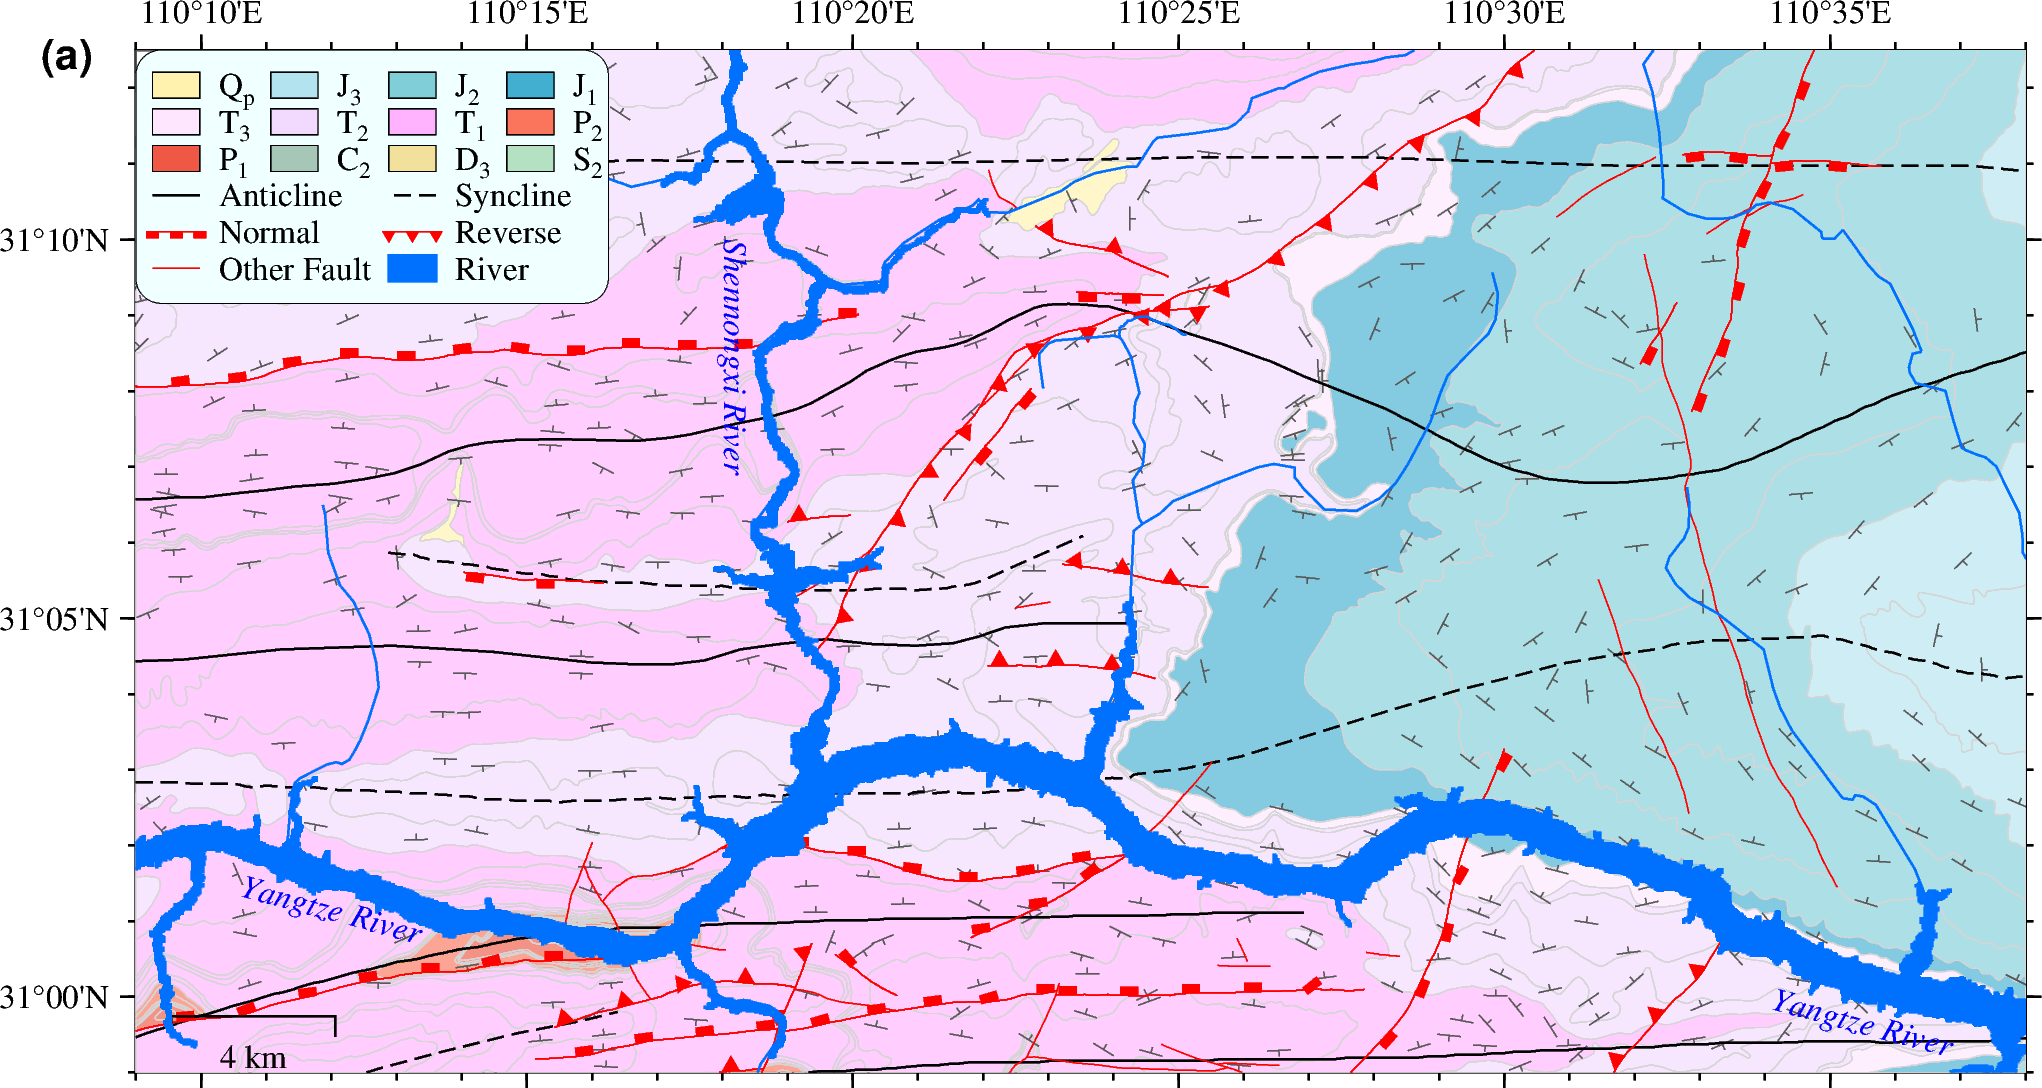

In [9]:
# plot Badong gelogical mapview
region = [110+10/60,110+37/60,30.0+59/60,31+12.5/60]
region = [110+9/60,110+38/60,30.0+59/60,31+12.5/60]
lon1,lon2,lat1,lat2 = region
bbox = box(min(lon1, lon2), min(lat1, lat2), max(lon1, lon2), max(lat1, lat2+0.1))
clipped_geo = geo.clip(bbox)
fig = pygmt.Figure()
pygmt.config(FONT='8p,4',MAP_FRAME_TYPE='plain',MAP_FRAME_PEN='0.5p')
fig.basemap(region=region,projection='M16c',frame=['xaf','yaf','WseN'])
with pygmt.clib.Session() as session:
    with pygmt.helpers.GMTTempFile() as tmpfile:
        session.call_module("mapproject", f"-Wh ->{tmpfile.name}")
        map_height = tmpfile.read().strip()
map_height = float(map_height)

# plot the stratum
idx = 0
for i,key in enumerate(list(geo_strata)):
    name = ' '.join(key.split('_'))
    name = key
    array = clipped_geo[clipped_geo['name'] == name]
    color = geo_strata[key]['color']
    label = geo_strata[key]['label']
    if len(array) <= 0:continue
    if idx == 0 : label=label+'+N4'
    idx = idx+1
    fig.plot(data=array,fill=color,label=label)
    fig.plot(data=array,pen='0.2p,gray')
fig.plot(data=strikes_df,style='kgeo-plane_gentle/0.2c')
fig.plot(x=[lon1,lon1,lon2,lon2,lon1],y=[lat1,lat2,lat2,lat1,lat1],fill='white@65')

# folds
fig.plot(data=anticline,pen='0.7p',label='Anticline+N2')
fig.plot(data=syncline,pen='0.7p,--',label='Syncline')

# plot the faults and map_scale
fig.plot(data=fault,pen='0.25p,red',label='Fault+N3')
for i in range(len(normal)):
    line = normal.iloc[i]
    mark,label = 'l',None
    if line['mark'] == 'left':mark='l'
    if line['mark'] == 'right':mark='r'
    if i==0: label='Normal'
    fig.plot(data=line.geometry,style=f"f0.5c/0.15c+{mark}+b+o0.1c+p",fill='red',pen='0.25p,red',label=label)
for i in range(len(reverse)):
    line = reverse.iloc[i]
    mark,label = 'l',None
    if line['mark'] == 'left':mark='l'
    if line['mark'] == 'right':mark='r'
    if i==0:label='Reverse'
    fig.plot(data=line.geometry,style=f"f0.5c/0.15c+{mark}+t+o0.1c+p",fill='red',pen='0.25p,red',label=label)
fig.basemap(map_scale='jBL+c110.5/31+w4+lkm+a+o0.3c/0.3c')

# plot the rivers
fig.plot(data='TGR_data/geology/Rivers.gmt',pen='0.5p,0/112/255',close=False) # Yangtze river
fig.plot(data='TGR_data/geology/TGR.shp',pen='0.5p,0/112/255',fill='0/112/255',close=False,label='River+N1')

#fig.legend(position='jTR+w4.0c+o0.0c/0.0c',box='+gazure1+p0.1p+r')#,T='spec')

fig.text(x=110+18.2/60,y=31+8.3/60,text='Shennongxi River',font='8p,6,blue',angle=-90,justify='MC',offset='0.0c/0.1c')
fig.text(x=110+12/60,y=31+1/60,text="Yangtze River",font='8p,6,blue',angle=-15,justify='MC',offset='0.0c/0.1c')
fig.text(x=110+35.5/60,y=31-0.5/60,text='Yangtze River',font='8p,6,blue',angle=-15,justify='MC',offset='0.0c/0.1c')

fig.legend(spec='spec',position='jTL+w4.0c+o0.0c/0.0c',box='+gazure1+p0.1p+r')
fig.text(position='cTL',text='(a)',font='10p,1',offset='j-0.8c/-0.1c',fill='white',no_clip=True)

fig.show()

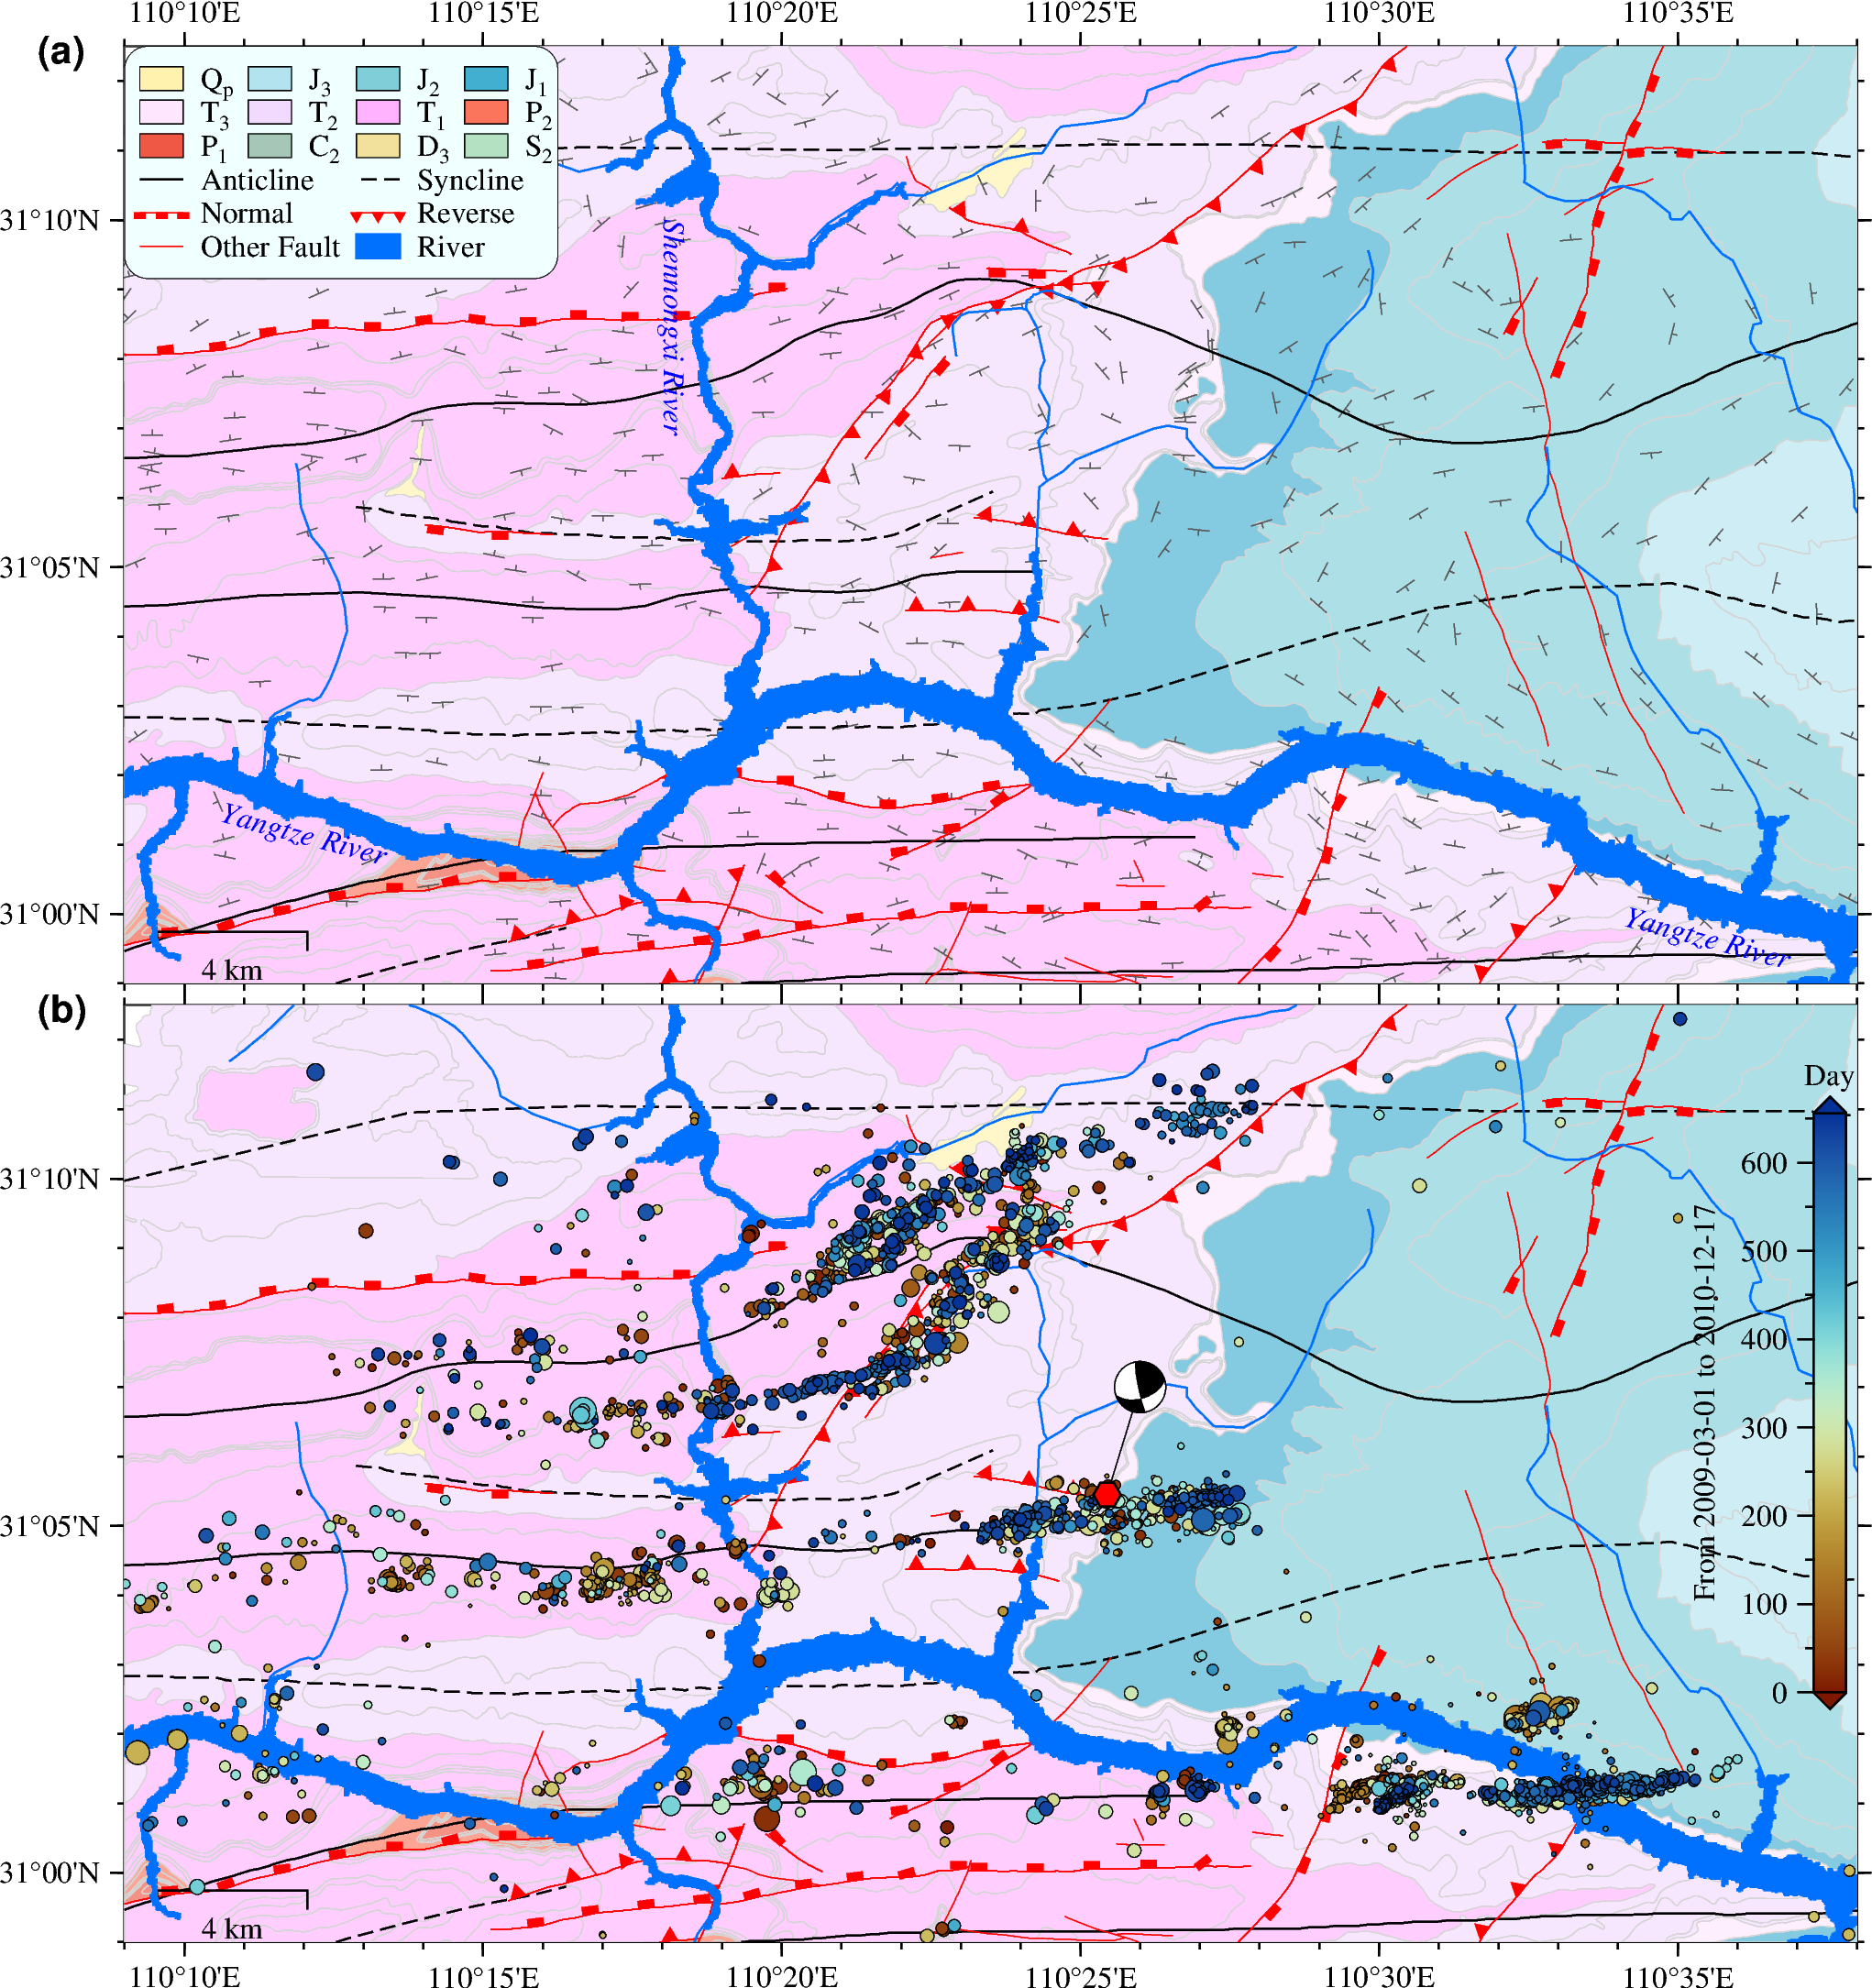

In [10]:
fig.shift_origin(yshift='-{}c'.format(map_height+0.2))
fig.basemap(region=region,projection='M16c',frame=['xaf','yaf','WSen'])
# plot the stratum
idx = 0
for i,key in enumerate(list(geo_strata)):
    name = ' '.join(key.split('_'))
    name = key
    array = clipped_geo[clipped_geo['name'] == name]
    color = geo_strata[key]['color']
    label = geo_strata[key]['label']
    if len(array) <= 0:continue
    if idx == 0 : label=label+'+N4'
    idx = idx+1
    fig.plot(data=array,fill=color,label=label)
    fig.plot(data=array,pen='0.2p,gray')
fig.plot(x=[lon1,lon1,lon2,lon2,lon1],y=[lat1,lat2,lat2,lat1,lat1],fill='white@65')

# folds
fig.plot(data=anticline,pen='0.7p',label='Anticline+N2')
fig.plot(data=syncline,pen='0.7p,--',label='Syncline')

# plot the faults and map_scale
fig.plot(data=fault,pen='0.25p,red',label='Fault+N3')
for i in range(len(normal)):
    line = normal.iloc[i]
    mark,label = 'l',None
    if line['mark'] == 'left':mark='l'
    if line['mark'] == 'right':mark='r'
    if i==0: label='Normal'
    fig.plot(data=line.geometry,style=f"f0.5c/0.15c+{mark}+b+o0.1c+p",fill='red',pen='0.25p,red',label=label)
for i in range(len(reverse)):
    line = reverse.iloc[i]
    mark,label = 'l',None
    if line['mark'] == 'left':mark='l'
    if line['mark'] == 'right':mark='r'
    if i==0:label='Reverse'
    fig.plot(data=line.geometry,style=f"f0.5c/0.15c+{mark}+t+o0.1c+p",fill='red',pen='0.25p,red',label=label)
fig.basemap(map_scale='jBL+c110.5/31+w4+lkm+a+o0.3c/0.3c')

# plot the rivers
fig.plot(data='TGR_data/geology/Rivers.gmt',pen='0.5p,0/112/255',close=False) # Yangtze river
fig.plot(data='TGR_data/geology/TGR.shp',pen='0.5p,0/112/255',fill='0/112/255',close=False,label='River+N1')

# plot the earthquake catalog
pygmt.makecpt(cmap='roma',series=[0,catalog.reltime.max(),1],continuous=True,output='time.cpt')
fig.plot(x=catalog.longitude,y=catalog.latitude,style='cc',size=0.06*(catalog.magnitude+1),fill=catalog.reltime,cmap='time.cpt',pen='0.2p')
fig.colorbar(position=f'jTR+w{map_height*0.618}c/0.3c+o0.1c/1.0c+m+e',frame=['xa100f50+lFrom 2009-03-01 to 2010-12-17','y+lDay'],cmap='time.cpt')

# plot meca
cap['plot_longitude'] = 110+26/60
cap['plot_latitude'] = 31+7/60
line = cap[cap.label=='Eq3']
meca = {'longitude':line.longitude,'latitude':line.latitude,'depth':line.depth,'magnitude':line.magnitude,'strike':line.strike1,'dip':line.dip1,'rake':line.rake1,'plot_longitude':line.plot_longitude,'plot_latitude':line.plot_latitude}
fig.meca(spec=meca,scale='0.5c',convention='aki',offset=True)
fig.plot(x=cap.longitude,y=cap.latitude,style='h0.1i',fill='red',pen='0.5p')

fig.text(position='cTL',text='(b)',font='10p,1',offset='j-0.8c/-0.1c',fill='white',no_clip=True)
fig.show()

In [11]:
fig.savefig('plotting_figures'+os.sep+'FigureS9_geological_Badong.png',dpi=600)
fig.savefig('plotting_figures'+os.sep+'FigureS9_geological_Badong.pdf')